## Semi-structured RAG



Many documents contain a mixture of content types, including text and tables. 

Semi-structured data can be challenging for conventional RAG for at least two reasons: 

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search 

This cookbook shows how to perform RAG on documents with semi-structured data: 

* We will use [Unstructured](https://unstructured.io/) to parse images, text and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text along with table summaries better suited for retrieval.
* We will use [LCEL](https://python.langchain.com/docs/expression_language/) to implement the chains used.


## Setting poppler path

In [1]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\poppler-25.07.0\Library\bin"


In [2]:
import shutil
print(shutil.which("pdfinfo"))

C:\Program Files\poppler-25.07.0\Library\bin\pdfinfo.EXE


## Load the Data

Here we will load the source data and our strategy is to extract `images,tables and text` sepearately and embed them to be stored in a vector database.
<br>For that `We will use unstrcutredpdfloader twice:`
- 1.First to get images and tables (we dont use chunking startegy so we get tables)
- 2.Second time to get the texts and chunk them to the required batches

### Extracting Images and Tables

In [ ]:
# lets get the tables,images
from langchain_community.document_loaders import UnstructuredPDFLoader

doc = './IF10244.pdf'
# Extract tables
loader = UnstructuredPDFLoader(file_path=doc,
                               strategy='hi_res',
                               extract_images_in_pdf=True,
                               infer_table_structure=True,
                               mode='elements',
                               image_output_dir_path='./figures'
                               )
data = loader.load()

c:\Studies\projects_bkr\learn\RAG Projects\rag_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
len(data)

48

In [5]:
# count the types of categories in the data
category_count={}
for doc in data:
    if doc.metadata['category'] in category_count:
        category_count[doc.metadata['category']]+=1
    else:
        category_count[doc.metadata['category']]=1

category_count

{'Image': 5,
 'NarrativeText': 20,
 'Title': 11,
 'FigureCaption': 6,
 'Table': 2,
 'UncategorizedText': 3,
 'Header': 1}

In [6]:
# Extarxt tables
Tables=[doc for doc in data if doc.metadata['category']=="Table"]
Tables

[Document(metadata={'source': './IF10244.pdf', 'detection_class_prob': 0.9197547435760498, 'coordinates': {'points': ((np.float64(165.53562927246094), np.float64(1271.2908935546875)), (np.float64(165.53562927246094), np.float64(1967.351318359375)), (np.float64(820.4866943359375), np.float64(1967.351318359375)), (np.float64(820.4866943359375), np.float64(1271.2908935546875))), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'last_modified': '2025-09-02T11:45:21', 'text_as_html': '<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>DOI</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0

In [7]:
Images=[doc for doc in data if doc.metadata['category']=="Image"]
Images

[Document(metadata={'source': './IF10244.pdf', 'coordinates': {'points': ((np.float64(160.0), np.float64(1.9444444444445708)), (np.float64(160.0), np.float64(257.63888888888886)), (np.float64(1539.6944444444443), np.float64(257.63888888888886)), (np.float64(1539.6944444444443), np.float64(1.9444444444445708))), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'last_modified': '2025-09-02T11:45:21', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'image_path': 'c:\\Studies\\projects_bkr\\learn\\RAG Projects\\Semi_Structured_rag\\figures\\figure-1-1.jpg', 'file_directory': '.', 'filename': 'IF10244.pdf', 'category': 'Image', 'element_id': '12c9f5a95f90b033a037021b22372f44'}, page_content='a. aa = Informing the legislative debate since 1914 Congressional Research Service'),
 Document(metadata={'source': './IF10244.pdf', 'coordinates': {'points': ((np.float64(869.9999999999999), np.float64(413.7499999999998)), (np.float64(869.9999999999999), np.f

###  Read the tables

In [8]:
from IPython.display import HTML, display, Markdown

for i,table in enumerate(Tables):
    display(Markdown(f"**Table:{i+1}**"))
    display(Markdown(table.metadata["text_as_html"]))
    print(".................................................")

**Table:1**

<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>DOI</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45.6</td><td>39.6</td><td>44.6</td><td>45.0</td><td>$7.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td colspan="6">Acres Burned (millions)</td></tr><tr><td>Federal</td><td>46</td><td>3.1</td><td>7.1</td><td>5.2</td><td>40</td></tr><tr><td>FS</td><td>2.3</td><td>0.6</td><td>48</td><td>4.1</td><td>19</td></tr><tr><td>DOI</td><td>2.3</td><td>2.3</td><td>2.3</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td><td>&lt;0.1</td></tr><tr><td>Nonfederal</td><td>4.1</td><td>1.6</td><td>3.1</td><td>Lg</td><td>3.6</td></tr><tr><td>Total</td><td>8.8</td><td>4.7</td><td>10.1</td><td>7.1</td><td>7.6</td></tr></tbody></table>

.................................................


**Table:2**

<table><thead><tr><th></th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td>Structures Burned</td><td>963</td><td>17,904</td><td>5,972</td><td>2,717</td></tr><tr><td>% Residences</td><td>46%</td><td>54%</td><td>60%</td><td>46%</td></tr></tbody></table>

.................................................


### Convert the table format (HTML to Markdown)

In [9]:
# lets conver the tables to markdown from html as they are easy to encode instead of html tags
import htmltabletomd
for table in Tables:
    table.page_content = htmltabletomd.convert_table(table.metadata['text_as_html'])

In [10]:
Tables

[Document(metadata={'source': './IF10244.pdf', 'detection_class_prob': 0.9197547435760498, 'coordinates': {'points': ((np.float64(165.53562927246094), np.float64(1271.2908935546875)), (np.float64(165.53562927246094), np.float64(1967.351318359375)), (np.float64(820.4866943359375), np.float64(1967.351318359375)), (np.float64(820.4866943359375), np.float64(1271.2908935546875))), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'last_modified': '2025-09-02T11:45:21', 'text_as_html': '<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>14.4</td><td>14.0</td><td>11.7</td></tr><tr><td>FS</td><td>5.6</td><td>5.3</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>DOI</td><td>7.0</td><td>5.3</td><td>7.6</td><td>7.6</td><td>5.8</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0

In [11]:
for table in Tables:
    print(table.page_content)
    print(".................")

|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| DOI | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 46 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 4.1 | 19 |
| DOI | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |

.................
|  | 2019 | 2020 | 2021 | 2022 |
| :--- | :--- | :--- | :--- | :--- |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |

.................


### Extract text and Chunk

In [12]:
# lets get text
from langchain_community.document_loaders import UnstructuredPDFLoader

doc = './IF10244.pdf'
# Extract tables
# takes 1-2 min on Colab
loader = UnstructuredPDFLoader(
                               file_path=doc,
                               strategy='hi_res',
                               extract_images_in_pdf=True,
                               infer_table_structure=True,
                               chunking_strategy="by_title", # section-based chunking
                               max_characters=4000, # max size of chunks
                               new_after_n_chars=4000, # preferred size of chunks
                               combine_text_under_n_chars=2000, # smaller chunks < 2000 chars will be combined into a larger chunk
                               mode='elements',
                               image_output_dir_path='./figures')
texts= loader.load()

In [13]:
len(texts)

5

In [14]:
# count the types of categories in the data
text_category_count={}
for doc in texts:
    if doc.metadata['category'] in text_category_count:
        text_category_count[doc.metadata['category']]+=1
    else:
        text_category_count[doc.metadata['category']]=1

text_category_count

{'CompositeElement': 5}

## View Extarcted images

**Image:1**

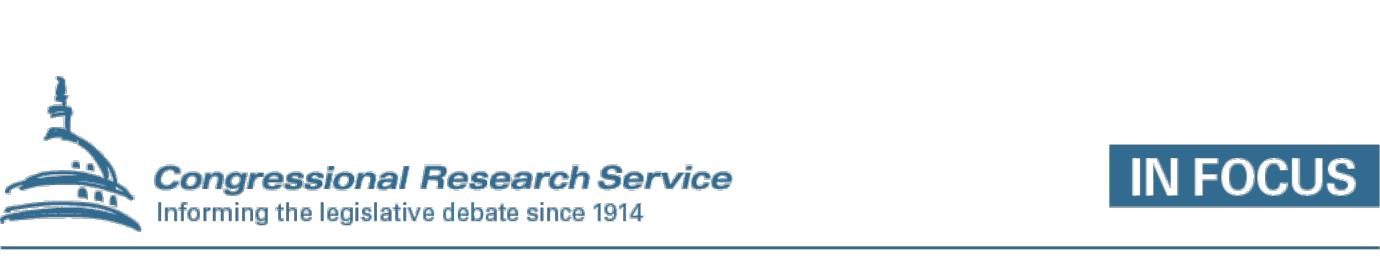

..........................................................


**Image:2**

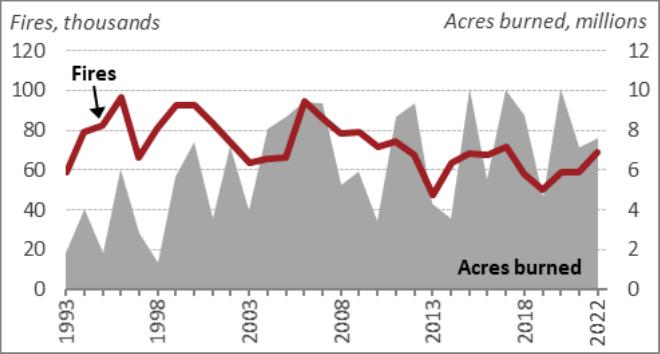

..........................................................


**Image:3**

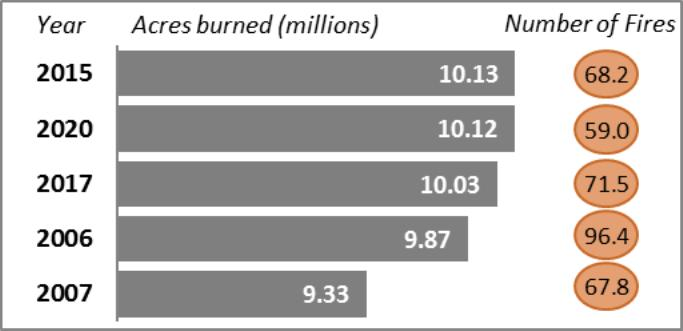

..........................................................


**Image:4**

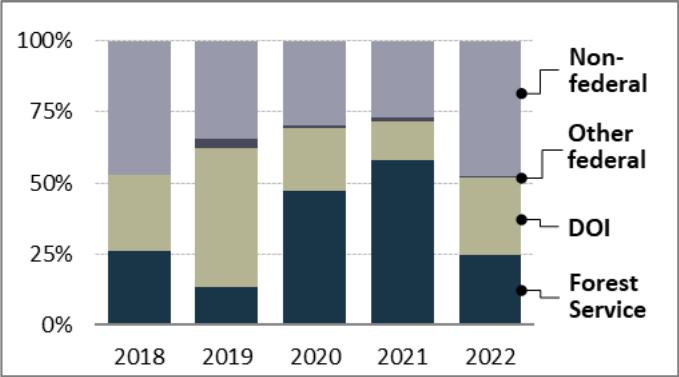

..........................................................


**Image:5**

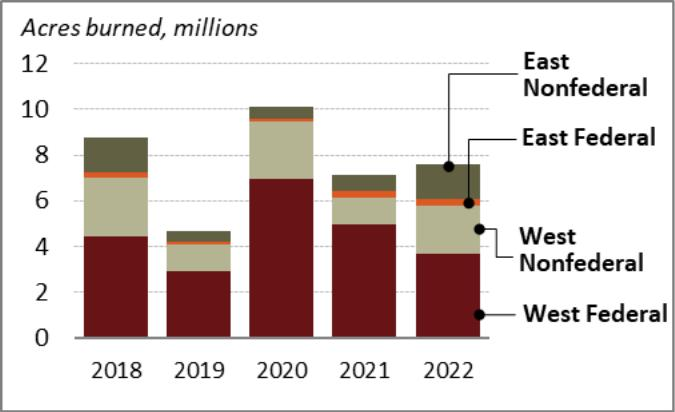

..........................................................


In [15]:
from IPython.display import Image, display
import glob

image_paths = glob.glob("./figures/*")

for i,path in enumerate(image_paths):
    display(Markdown(f"**Image:{i+1}**"))
    display(Image(filename=path, width=400, height=300))
    print("..........................................................")


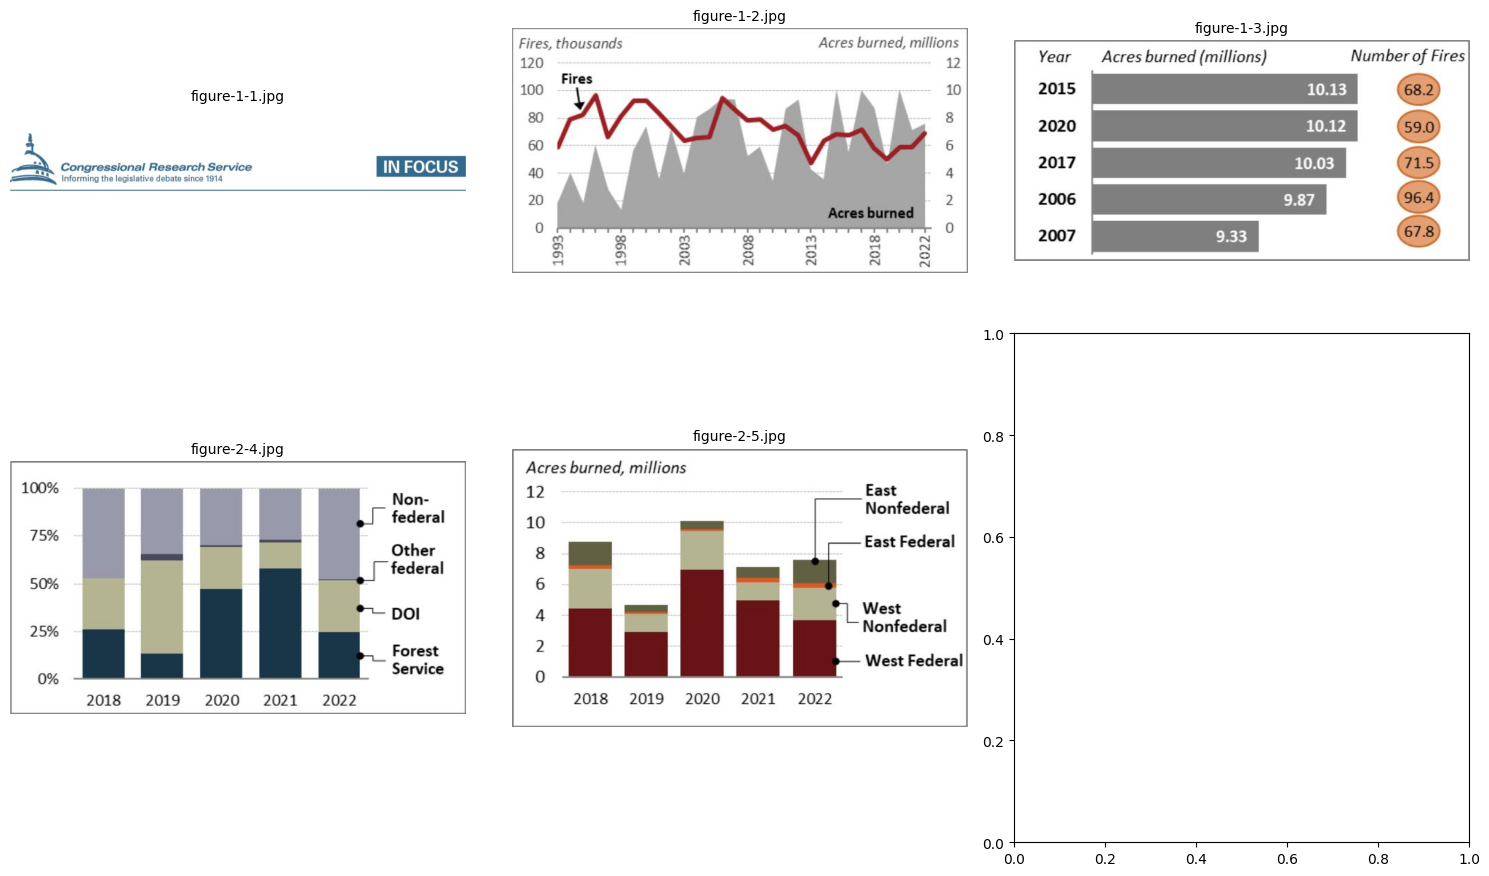

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your figures folder
path = "./figures"

# List all image files (filter common formats)
images = [f for f in os.listdir(path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))]

# Number of columns (3 side by side)
cols = 3
rows = (len(images) + cols - 1) // cols  # auto-calculate rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes (for easy indexing)
axes = axes.flatten()

for i, img_file in enumerate(images):
    img = mpimg.imread(os.path.join(path, img_file))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(img_file, fontsize=10)



plt.tight_layout()
plt.show()


## Environment Setup

In [17]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [18]:
os.environ["openai_api_key"]=os.getenv("openai_api_key")
os.environ["groq_api_key"]=os.getenv("groq_api_key")

## Load the models

In [19]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

chatgpt=ChatOpenAI(
    model="gpt-4o",
    temperature=0
)
chatgroq=ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0
    
)



## Text and Table summaries



We will use GPT-4o to produce table and, text summaries.

Text summaries are advised if using large chunk sizes (e.g., as set above, we use 4k token chunks).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Building Prompt Template

In [20]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Do not add redundant words like Summary.
Just output the actual summary content.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)


### LCEL Chains

In [21]:
Summary_chain=(
    {"element":RunnablePassthrough()}
    |
    prompt
    |
    chatgpt
    |
    StrOutputParser()
)

### Text and Table Summaries

In [22]:
Text_Summary=[]
Table_Summary=[]

Text_Summary=Summary_chain.batch([doc.page_content for doc in texts],{"max_concurrency": 5})
Table_Summary=Summary_chain.batch([doc.page_content for doc in Tables],{"max_concurrency": 5})


In [23]:
print(f"length of text summary:{len(Text_Summary)}")
print(f"length of Table summary:{len(Table_Summary)}")


length of text summary:5
length of Table summary:2


In [24]:
for i,summary in enumerate(Table_Summary):
    print(f"Summary of Table:{i+1}")
    print(summary)
    print("..........")

Summary of Table:1
The table provides data on the number of fires and acres burned in the United States from 2018 to 2022, categorized by federal and nonfederal sources. 

For the number of fires (in thousands), federal fires fluctuated, peaking at 14.4 thousand in 2020 and decreasing to 11.7 thousand in 2022. The Forest Service (FS) saw a significant increase in 2022 to 59 thousand fires, while the Department of the Interior (DOI) had a more stable trend, with a slight decrease to 5.8 thousand in 2022. Nonfederal fires remained relatively stable, with a notable drop to $7.2 thousand in 2022, which appears to be a data entry error. The total number of fires increased to 69 thousand in 2022.

For acres burned (in millions), federal acres burned varied, with a significant increase in 2022 to 40 million acres. The FS had a notable spike in 2020 with 48 million acres burned, decreasing to 19 million in 2022. DOI's acres burned remained consistent, with a slight decrease to 2.1 million in 2

## Image summaries

We will use [GPT-4o](https://openai.com/index/hello-gpt-4o/) to produce the image summaries.

* We pass base64 encoded images

In [25]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", temperature=0)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or tables also.
                These summaries will be embedded and used to retrieve the raw image for question answering.
                Give a detailed summary of the image that is well optimized for retrieval.
                Do not add additional words like Summary, This image represents, etc.
             """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

In [26]:
image_summaries

['Congressional Research Service logo featuring a stylized dome of the U.S. Capitol building on the left. The text "Congressional Research Service" is written in blue, followed by the tagline "Informing the legislative debate since 1914." On the right, a blue rectangular box contains the words "IN FOCUS" in white capital letters. The overall design is clean and professional, with a focus on legislative research and information dissemination.',
 'Line and area chart depicting the number of fires and acres burned in the U.S. from 1993 to 2022. The left y-axis represents fires in thousands, while the right y-axis shows acres burned in millions. The x-axis displays years from 1993 to 2022. A red line indicates the number of fires, peaking around 1996 and 2006, with fluctuations throughout the period. A gray shaded area represents acres burned, with notable peaks around 2006, 2012, and 2020. The chart highlights trends in fire occurrences and the extent of land affected over nearly three de

In [27]:
# imgs_base64

**Image:1**

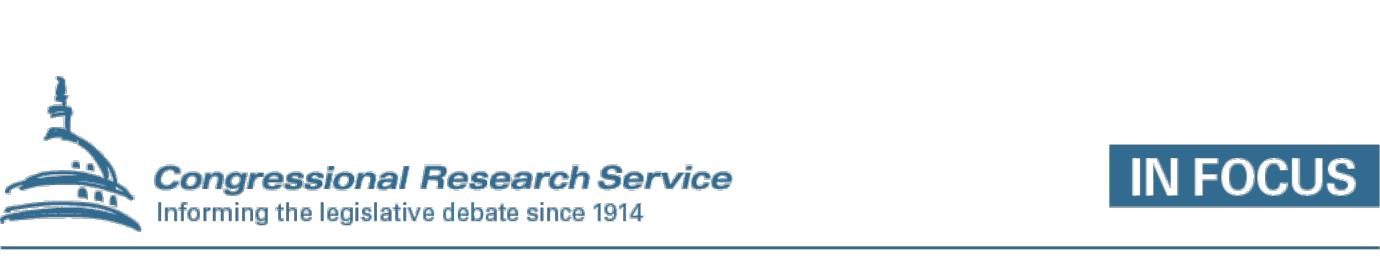

Congressional Research Service logo featuring a stylized dome of the U.S. Capitol building on the left. The text "Congressional Research Service" is written in blue, followed by the tagline "Informing the legislative debate since 1914." On the right, a blue rectangular box contains the words "IN FOCUS" in white capital letters. The overall design is clean and professional, with a focus on legislative research and information dissemination.

..........................................................


**Image:2**

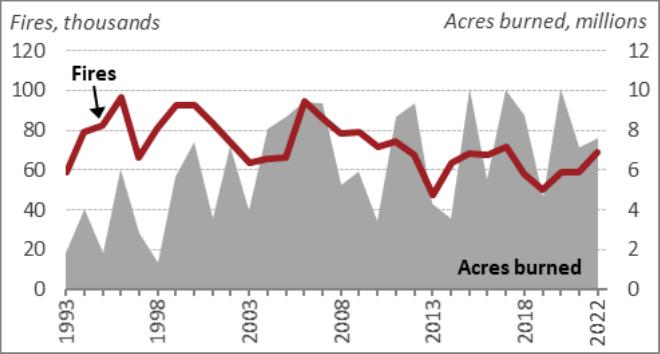

Line and area chart depicting the number of fires and acres burned in the U.S. from 1993 to 2022. The left y-axis represents fires in thousands, while the right y-axis shows acres burned in millions. The x-axis displays years from 1993 to 2022. A red line indicates the number of fires, peaking around 1996 and 2006, with fluctuations throughout the period. A gray shaded area represents acres burned, with notable peaks around 2006, 2012, and 2020. The chart highlights trends in fire occurrences and the extent of land affected over nearly three decades.

..........................................................


**Image:3**

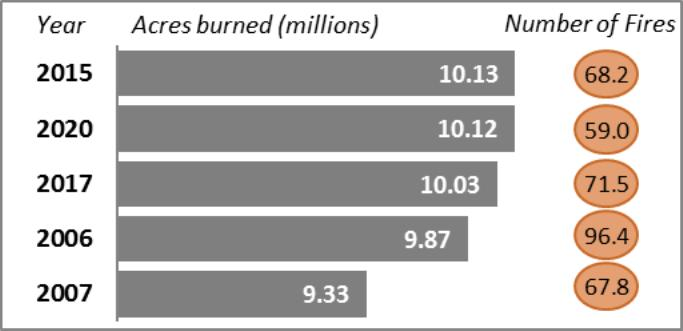

Bar chart displaying data on acres burned and number of fires for specific years. The years listed are 2015, 2020, 2017, 2006, and 2007. Acres burned in millions are shown as horizontal bars: 2015 (10.13), 2020 (10.12), 2017 (10.03), 2006 (9.87), and 2007 (9.33). Corresponding number of fires are in orange circles: 2015 (68.2), 2020 (59.0), 2017 (71.5), 2006 (96.4), and 2007 (67.8). The chart highlights the relationship between acres burned and number of fires over these years.

..........................................................


**Image:4**

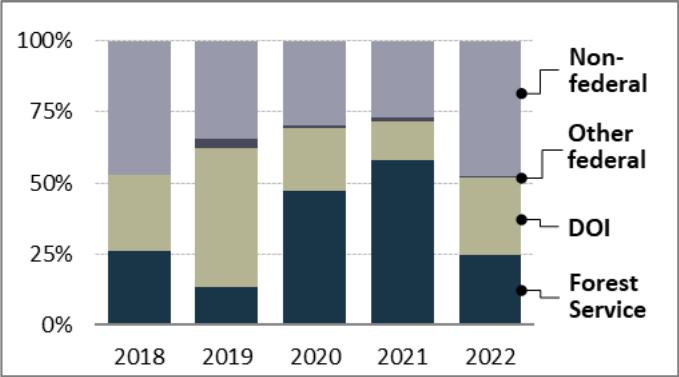

Stacked bar chart showing percentage distribution of land management from 2018 to 2022. Categories include Non-federal, Other federal, DOI, and Forest Service. Each year is represented by a vertical bar divided into segments for each category. Non-federal is the top segment, followed by Other federal, DOI, and Forest Service at the bottom. The chart indicates changes in the proportion of each category over the years, with noticeable variations in the size of the segments, particularly in the DOI and Forest Service categories. The y-axis represents percentage from 0% to 100%, and the x-axis lists the years 2018 through 2022.

..........................................................


**Image:5**

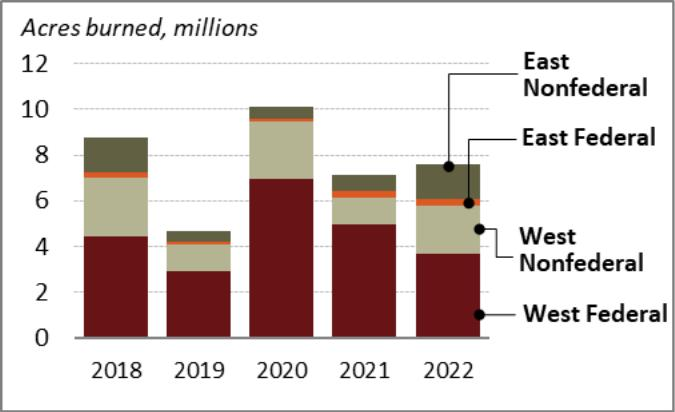

Bar chart depicting acres burned in millions from 2018 to 2022, categorized by East Nonfederal, East Federal, West Nonfederal, and West Federal regions. Each year is represented by a stacked bar showing the contribution of each category. The West Federal region consistently shows the largest portion, particularly in 2020 and 2022. The East Nonfederal and East Federal regions have smaller contributions. The total acres burned peaked in 2020, with a noticeable decrease in 2021, followed by an increase in 2022. The chart uses different colors to distinguish between the categories.

..........................................................


In [28]:
from IPython.display import Image, display
import glob

image_paths = glob.glob("./figures/*")

for i,path in enumerate(image_paths):
    display(Markdown(f"**Image:{i+1}**"))
    display(Image(filename=path, width=400, height=300))
    display(Markdown(image_summaries[i]))
    print("..........................................................")


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image (and / or text, table) summaries, but retrieve raw images (along with raw texts or tables).

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [29]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Add to vectorstore & docstore

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary):

* Store the raw texts, tables, and images in the `docstore` (here we are using Redis).
* Store the texts, table summaries, and image summaries and their corresponding embeddings in the `vectorstore` (here we are using Chroma) for efficient semantic retrieval.
* Connect them using a common `document_id`


In [41]:
import uuid
import json
import pandas as pd

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.storage import RedisStore
from langchain_community.utilities.redis import get_client
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# -------------------------
# Helper functions
# -------------------------

def serialize_table(table):
    """Convert a DataFrame or dict to JSON string."""
    if isinstance(table, pd.DataFrame):
        return table.to_json()
    elif isinstance(table, dict):
        return json.dumps(table)
    else:
        return str(table)

def add_documents_to_store(docstore, vectorstore, summaries, contents, id_key="doc_id", content_type="text"):
    """
    Add documents to vectorstore and docstore.
    content_type: 'text' or 'table' (images as base64 strings are treated as text)
    """
    doc_ids = [str(uuid.uuid4()) for _ in contents]

    # Serialize content for Redis
    serialized_contents = []
    for c in contents:
        if content_type == "table":
            serialized_contents.append(serialize_table(c))
        else:  # text or base64 image
            serialized_contents.append(str(c))

    # Create summary docs for vectorstore
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(summaries)
    ]

    # Add to vectorstore and docstore
    vectorstore.add_documents(summary_docs)
    docstore.mset(list(zip(doc_ids, serialized_contents)))

# -------------------------
# Initialize vectorstore
# -------------------------

chroma_db = Chroma(
    collection_name="mm_rag",
    embedding_function=openai_embed_model,  # your OpenAI embedding model
    collection_metadata={"hnsw:space": "cosine"},
)

# -------------------------
# Initialize Redis docstore
# -------------------------

client = get_client('redis://localhost:6379')
redis_store = RedisStore(client=client)
print("Redis PING:", client.ping())

# -------------------------
# Create multi-vector retriever
# -------------------------

id_key = "doc_id"
retriever_multi_vector = MultiVectorRetriever(
    vectorstore=chroma_db,
    docstore=redis_store,
    id_key=id_key,
)

# -------------------------
# Add documents step by step
# -------------------------

# Add texts
if Text_Summary and texts:
    add_documents_to_store(redis_store, chroma_db, Text_Summary, texts, id_key=id_key, content_type="text")

# Add tables
if Table_Summary and Tables:
    add_documents_to_store(redis_store, chroma_db, Table_Summary, Tables, id_key=id_key, content_type="table")

# Add images (already base64 strings)
if image_summaries and imgs_base64:
    add_documents_to_store(redis_store, chroma_db, image_summaries, imgs_base64, id_key=id_key, content_type="text")

print("Multi-vector retriever is ready!")


Redis PING: True
Multi-vector retriever is ready!


In [42]:
retriever_multi_vector

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x0000020EFF7C8150>, docstore=<langchain_community.storage.redis.RedisStore object at 0x0000020EFF7C8910>, search_kwargs={})

## Check the retrieval

In [43]:
# Check retrieval
query = "Analyze the wildfires trend with acres burned over the years"
docs = retriever_multi_vector.invoke(query, limit=5)

len(docs)

3

In [44]:
docs

[b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mjwH/AMiyn/XV/wCddNQBzP8Awgeif3J/+/po/wCED0T+5P8A9/TXTUUAcz/wgeif3J/+/po/4QPRP7k//f010rMqKWdgqjqScAUKysoZWBU8gg8UAc1/wgeif3J/+

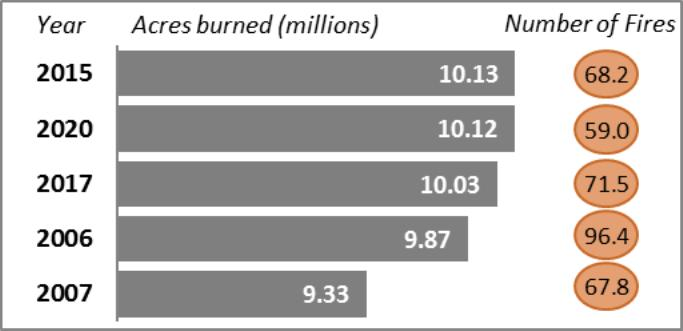

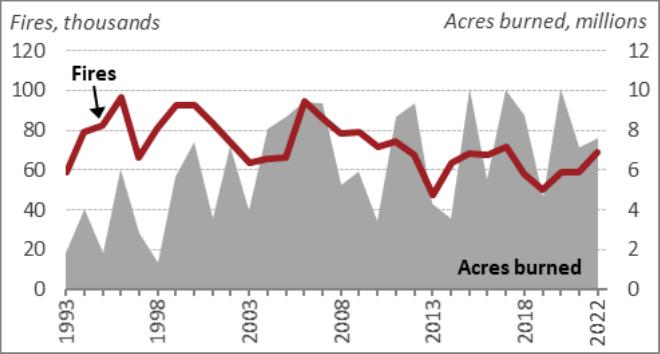

Could not decode item 2: 'bytes' object has no attribute 'page_content'


In [49]:
from IPython.display import HTML, display, Image
from PIL import Image
import base64
from io import BytesIO

def show_images_and_text(docs):
    for i, doc in enumerate(docs):
        try:
            """Disply base64 encoded string as image"""
            # Decode the base64 string
            img_data = base64.b64decode(doc)
            # Create a BytesIO object
            img_buffer = BytesIO(img_data)
            # Open the image using PIL
            img = Image.open(img_buffer)
            display(img)
        except Exception:
            # If not an image, try to decode as text
            try:
                display(Markdown(doc.page_content))
            except Exception as e:
                print(f"Could not decode item {i}: {e}")


show_images_and_text(docs)


In [54]:
from IPython.display import display, Markdown
from PIL import Image
import base64
from io import BytesIO

def show_images_and_text(docs):
    for i, doc in enumerate(docs):
        try:
            # Case 1: Try image
            if isinstance(doc, (bytes, str)):
                try:
                    img_data = base64.b64decode(doc)
                    img = Image.open(BytesIO(img_data))
                    display(img)
                    continue
                except Exception:
                    pass  # not an image, try text

            # Case 2: Text documents
            text = None
            if hasattr(doc, "page_content"):   # LangChain Document
                text = doc.page_content
            else:                              # Raw string or other
                text = str(doc)

            if text:
                display(Markdown(text))  # ✅ shows just the text (no "page_content=")
                
        except Exception as e:
            print(f"Could not decode item {i}: {e}")


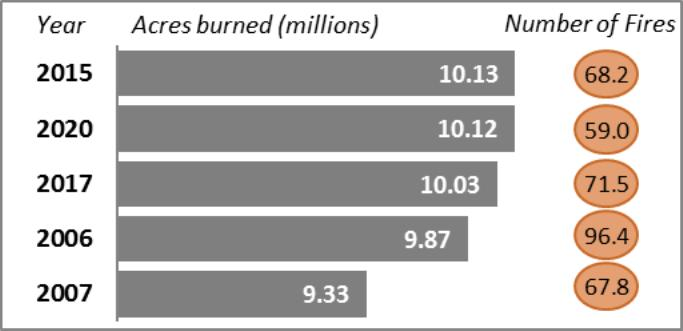

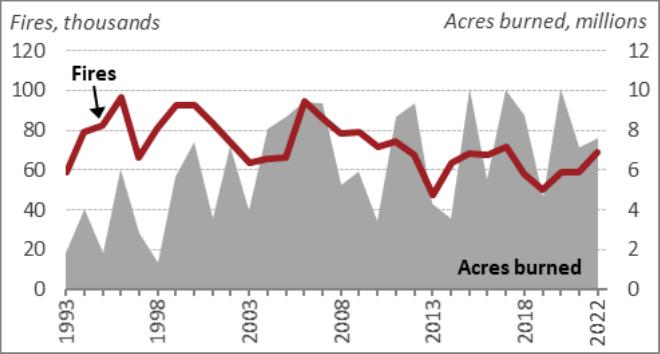

b"page_content='a. aa = Informing the legislative debate since 1914 Congressional Research Service\n\nUpdated June 1, 2023\n\nWildfire Statistics\n\nWildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)\xe2\x80\x94within the U.S. Department of Agriculture\xe2\x80\x94carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.\n\nFigure 1. Annual Wildfires and Acres Burned, 1993-2022\n\nFires, thousands Acres burned, millions 120 12 100 Fires 10 80 oN FD\n\nWildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).\n\nSource: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.\n\nFrom 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).\n\nAs of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.' metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-09-02T11:45:21', 'page_number': 1, 'orig_elements': 'eJzNWG1v2zgS/iuEgQMSwBJIipLIAPchlyKHHHDZYt3FfaiLgKIom1tZEvSS1Lu4/34zlJworm9xDeDsFWhhjjjDeeM8D/v594Ut7c5W/YPLF1dkUchUJCZOAxvJLBBRbgOZWBqYOBFpxIWUSiyWZLGzvc51r0Hn94Wp6zZ3le5t59el3tdD/7C1brPtQcI5paAziZ9c3m9BylIvbWpX9aj3+TNLaAgiFqovS3JY8TgNE7+OIxWmJwS4H9aLbt/1dodRfHTfbLlqtLGLf8OHwpW23zfWf/r4T/Tf7fTGPjTae7IwV+v1qh9yZ7v1umnrX63pu4fsa7tel1a31Xr98/XfycfpA+y1O/ew6tvB9ENr84dWb9brwm1g0R1+BCxg4a/NZuEjrzYDHOjDXNhqs/jipV3/sKtzVzjrk88pjwOqAso/MXYl4ivOULtBV6thl9kW04YR9fYbJnahQ6I1+Su5q4q63blqQ/qtJaXduK7UvXu0JLcZ1IV0rjKWMMUEuamrDfjZubrSJfnZdhCh2ZKVbR8dJAytT7m6wyRhBo+7RMmk0GkRBTKlJoCm0IGieRqkTOaFVZYam56vS7hKQ459IEPp++AgUHQSxIKH0SmBV/nDXsltDzWG3DwYqE/3AN2QwTYaxnCMOt1MZyvvLw1kz+bkH0MFxQP/KY/mBbrXbevL/AkVThSqMJFQJomC1MoEC8UDXfAs0JHgcWK0kHl07uvMVRSmswsdCRlGuI6FwOt7vB73v61IMmapeOci/cuVeeFaS1Y91KLrnenmNfrk+vLkJcqEyVUe50GUwYAVSkFZRGKDmDNqKDcRS9W5axNJ+qo2ksahwLWMBF6Y4/W4/221UTGn0Z9Um45oKNBQNXBSBRfKy5YEhmIJUx/GZon5q+BXYPTQvewYKj3027p1v4FsO+x0dbRBVzmxndHNQUSKtt6RBn6Z1mUgzYa2IgdQCX2XTP7AnqauOpeVlsD8ntben74mT8++91vdkwyGekXqilR1VdjctjC8Lzo0tiRlbXQ5+tK07hFklwQizcE/+83YpvfmvQQ9wQKhY3tyMAQZrAygH8QLAgJd1thxssCn1vq2Bd8/AbgcVDb1o20r/EBc98ZQDra8Z6P52xq29Qc0Ihe3q8v1wCkTT67fghbi2y/hKiQfbKPb3p9fF+R60zozlAjH43YDoxEDgmvwfDyB8kGkXgdzNTkNMZq27jpvm6mI7FxZQgOjGC0U/sO97kfEPHjoLwC5uAcPR9dfe4Q6d1VvWwfpuPjw093ldHz34s+zA5iyHdjF/FREUPq9D9XhfDjkKxQWjZSuQCPFgFbH6gOct4/YmDU40JJmyEpnDs2AW+6gKnDGuNHb7MIfwhSRxlmGg0oWTAVCGBlIBmQRiplxo6WxZ6SIQDhChnOITXNpXAuaHpA+ikJ1QjBqvG1yiURw+c6T69aTSOC25LqqBij7bJRBFa99W/wNRovNgQErFQVwBp8XcrRwoxsM6WQhM6XSPCuCIhXA4jSnQUaFDjJA5KhQMhMpP2shQSTYRA6mdZrIMJ7qdlowavxf8n1+dr5/O4IOINLQ+Wk+9kE29cE0NDrCOIW/hMEg8SrwC7Cc1Pfk9sP/xPCzyFJpizhIdATkRMcCuH6iA5tGNMmlEDqj5yMnsQqBxclITi/BcQ1B8bEXJI/D+IRg1HgrPRGS/VnUsXumjmRry4ZAHYeub/Hl1sAxI+I9w4aGAB5dvw8nUIJMwkMPqgDAvWvAf4/tr0DLI5FH+T08AKcyIb7cWPwCMHZ3c3MJhCh3Bk/1OI0WRscRgPQ4h16wHGD/UbdOI+ZnALNb3cFzExpSIz/qPKUq9wR5wvgsxUgiSvZwxSa0n1n3jayLYuQm42HlHnBuCwERXXb182lLAoEgcQDreCjQuOnQi84ChZhGJ8Dyyj97oe0ogt8hBP3oc4HHpnQJVZsFtYWP0336LxrhETiPkeBP3DEOA8zNC57n9YA5whwcDB3sTlrTgRO/gXFOO3IRhUdU5BKCKPHub7ZEE+BlGkv3ksMxgtqYoW1nOXxtFo1NTlykcplQevlj+K+0YUbnIjCC54GgNglUypKgoMqYWLLIWHlu/E9THvIZ/suYHkZFlCLcfycYNd44GqhK3xv/V/XQGntF8F567EcK54c5WQ27nW73nge8vDkPLdXapm6RrN8Dz78iH3AsAEUsIbSRM6LaC5HQMwCZOCaOk/nb6EhrxttROHuOjDT+hziI5qlNYhYHKjNAJmMTBVmaxEEW2ziL4yJj/OzNJIFipLNmYpSpZ/LIPfJ8Jxl13thOQkXpe9NJfJTCuyjC5xgyRSQRFprpCf/R1XzCJWwpgC88zQjnNEh8w1SvpyE/eqq4HWRgPsJDAJ/pyEQulZQzy1PfpWFyPFN/QtQQ9C/jU6oeH2n4dkJ/YaBdQ1K+ahyS7GhI/tg0S3PDWSFsIBhHEsxoICmVgSoyoMVxrgrDzt2AjMavnzMM/owC6LfEU53vJaPSG1uQpfF7/2fmtX/Gzv8rE+CsrQfoKSaXEaXHKPzcSZ5BxIwtAcenNui3gLBIJP6o2l/+A8XqwIE=', 'file_directory': '.', 'filename': 'IF10244.pdf', 'category': 'CompositeElement', 'element_id': '150202048ae0d2bf64f0f9b13527581a'}"

In [55]:
show_images_and_text(docs)

In [56]:
# Check retrieval
query = "Tell me about the percentage of residences burned by wildfires in 2022"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 4 docs
len(docs)

3

In [57]:
docs

[b"page_content='|  | 2019 | 2020 | 2021 | 2022 |\n| :--- | :--- | :--- | :--- | :--- |\n| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |\n| % Residences | 46% | 54% | 60% | 46% |\n' metadata={'source': './IF10244.pdf', 'detection_class_prob': 0.892244815826416, 'coordinates': {'points': ((np.float64(870.3600463867188), np.float64(919.2681884765625)), (np.float64(870.3600463867188), np.float64(1085.7747802734375)), (np.float64(1535.298583984375), np.float64(1085.7747802734375)), (np.float64(1535.298583984375), np.float64(919.2681884765625))), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'last_modified': '2025-09-02T11:45:21', 'text_as_html': '<table><thead><tr><th></th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td>Structures Burned</td><td>963</td><td>17,904</td><td>5,972</td><td>2,717</td></tr><tr><td>% Residences</td><td>46%</td><td>54%</td><td>60%</td><td>46%</td></tr></tbody></table>', 'filetype': 'application/pdf', 'la

## Utilities to separate retrieved elements

We need to bin the retrieved doc(s) into the correct parts of the GPT-4o prompt template.

Here we need to have text, table elements as one set of inputs and image elements as the other set of inputs as both require separate prompts in GPT-4o.

In [58]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content.decode('utf-8')
        else:
            doc = doc.decode('utf-8')
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

In [59]:
# Check retrieval
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 3 docs
len(docs)

3

In [60]:
docs

[b"page_content='Figure 4. Acreage Burned by Region and Ownership\n\nAcres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal oN FD Ww 2018 2019 2020 2021 2022\n\n2019 2020 2021 2022 Structures Burned 963 17,904 5,972 2,717 % Residences 46% 54% 60% 46%\n\nSource: NICC Wildland Fire Summary and Statistics annual reports.\n\nConflagrations\n\nOf the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations\xe2\x80\x94raging, destructive fires\xe2\x80\x94but predicting which fires will \xe2\x80\x9cblow up\xe2\x80\x9d into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 202

In [61]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.

    This function formats the provided context from `data_dict`, which contains
    text, tables, and base64-encoded images. It joins the text (with table) portions
    and prepares the image(s) in a base64-encoded format to be included in a message.

    The formatted text and images (context) along with the user question are used to
    construct a prompt for GPT-4o
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text and tables for analysis
    text_message = {
        "type": "text",
        "text": (
            f"""You are an analyst tasked with understanding detailed information and trends
                from text documents, data tables, and charts and graphs in images.
                You will be given context information below which will be a mix of text, tables,
                and images usually of charts or graphs.
                Use this information to provide answers related to the user question.
                Analyze all the context information including tables, text and images to generate the answer.
                Do not make up answers, use the provided context documents below
                and answer the question to the best of your ability.

                User question:
                {data_dict['question']}

                Context documents:
                {formatted_texts}

                Answer:
            """
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


# Create RAG chain
multimodal_rag = (
        {
            "context": itemgetter('context'),
            "question": itemgetter('input'),
        }
            |
        RunnableLambda(multimodal_prompt_function)
            |
        chatgpt
            |
        StrOutputParser()
)

# Pass input query to retriever and get context document elements
retrieve_docs = (itemgetter('input')
                    |
                retriever_multi_vector
                    |
                RunnableLambda(split_image_text_types))

# Below, we chain `.assign` calls. This takes a dict and successively
# adds keys-- "context" and "answer"-- where the value for each key
# is determined by a Runnable (function or chain executing at runtime).
# This helps in also having the retrieved context along with the answer generated by GPT-4o
multimodal_rag_w_sources = (RunnablePassthrough.assign(context=retrieve_docs)
                                               .assign(answer=multimodal_rag)
)

In [62]:
# Run RAG chain
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
response = multimodal_rag_w_sources.invoke({'input': query})
response

{'input': 'Tell me detailed statistics of the top 5 years with largest wildfire acres burned',
 'context': {'images': [],
  'texts': ["page_content='Figure 4. Acreage Burned by Region and Ownership\n\nAcres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal oN FD Ww 2018 2019 2020 2021 2022\n\n2019 2020 2021 2022 Structures Burned 963 17,904 5,972 2,717 % Residences 46% 54% 60% 46%\n\nSource: NICC Wildland Fire Summary and Statistics annual reports.\n\nConflagrations\n\nOf the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations—raging, destructive fires—but predicting which fires will “blow up” into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. Th

In [63]:
def multimodal_rag_qa(query):
    response = multimodal_rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources:
        display(Markdown(text))
        print()
    for img in img_sources:
        plt_img_base64(img)
        print()
    print('=='*50)

Answer:


The analysis of the wildfire trends and acres burned over the years reveals the following insights:

1. **Number of Fires**:
   - The number of wildfires has shown variability but a slight decrease over the last 30 years.
   - In the 1990s, there was an average of 78,600 wildfires annually.
   - From 2013 to 2022, the average number of wildfires annually was 61,410.
   - In 2022, there were 68,988 wildfires.

2. **Acres Burned**:
   - The number of acres burned annually has generally increased over the years.
   - In the 1990s, the average annual acreage burned was 3.3 million acres.
   - Since 2000, the average annual acreage burned increased to 7.0 million acres.
   - From 2013 to 2022, the average annual acreage burned was 7.2 million acres.
   - In 2022, 7.6 million acres were burned, with over 40% of those acres in Alaska.

3. **Specific Years**:
   - The years with the highest acres burned include 2015 (10.13 million acres), 2020 (10.12 million acres), and 2017 (10.03 million acres).
   - The number of fires in these years varied, with 2015 having 68.2 thousand fires, 2020 having 59.0 thousand fires, and 2017 having 71.5 thousand fires.

4. **Trend Observations**:
   - While the number of fires has decreased slightly, the area affected by these fires has increased, indicating that fires may be becoming larger or more intense.
   - The data suggests a trend towards fewer but more destructive fires in terms of acreage.

Overall, the trend indicates a shift towards larger fires affecting more acres, despite a decrease in the total number of fires.

----------------------------------------------------------------------------------------------------
Sources:


page_content='a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 12 100 Fires 10 80 oN FD

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.' metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-09-02T11:45:21', 'page_number': 1, 'orig_elements': 'eJzNWG1v2zgS/iuEgQMSwBJIipLIAPchlyKHHHDZYt3FfaiLgKIom1tZEvSS1Lu4/34zlJworm9xDeDsFWhhjjjDeeM8D/v594Ut7c5W/YPLF1dkUchUJCZOAxvJLBBRbgOZWBqYOBFpxIWUSiyWZLGzvc51r0Hn94Wp6zZ3le5t59el3tdD/7C1brPtQcI5paAziZ9c3m9BylIvbWpX9aj3+TNLaAgiFqovS3JY8TgNE7+OIxWmJwS4H9aLbt/1dodRfHTfbLlqtLGLf8OHwpW23zfWf/r4T/Tf7fTGPjTae7IwV+v1qh9yZ7v1umnrX63pu4fsa7tel1a31Xr98/XfycfpA+y1O/ew6tvB9ENr84dWb9brwm1g0R1+BCxg4a/NZuEjrzYDHOjDXNhqs/jipV3/sKtzVzjrk88pjwOqAso/MXYl4ivOULtBV6thl9kW04YR9fYbJnahQ6I1+Su5q4q63blqQ/qtJaXduK7UvXu0JLcZ1IV0rjKWMMUEuamrDfjZubrSJfnZdhCh2ZKVbR8dJAytT7m6wyRhBo+7RMmk0GkRBTKlJoCm0IGieRqkTOaFVZYam56vS7hKQ459IEPp++AgUHQSxIKH0SmBV/nDXsltDzWG3DwYqE/3AN2QwTYaxnCMOt1MZyvvLw1kz+bkH0MFxQP/KY/mBbrXbevL/AkVThSqMJFQJomC1MoEC8UDXfAs0JHgcWK0kHl07uvMVRSmswsdCRlGuI6FwOt7vB73v61IMmapeOci/cuVeeFaS1Y91KLrnenmNfrk+vLkJcqEyVUe50GUwYAVSkFZRGKDmDNqKDcRS9W5axNJ+qo2ksahwLWMBF6Y4/W4/221UTGn0Z9Um45oKNBQNXBSBRfKy5YEhmIJUx/GZon5q+BXYPTQvewYKj3027p1v4FsO+x0dbRBVzmxndHNQUSKtt6RBn6Z1mUgzYa2IgdQCX2XTP7AnqauOpeVlsD8ntben74mT8++91vdkwyGekXqilR1VdjctjC8Lzo0tiRlbXQ5+tK07hFklwQizcE/+83YpvfmvQQ9wQKhY3tyMAQZrAygH8QLAgJd1thxssCn1vq2Bd8/AbgcVDb1o20r/EBc98ZQDra8Z6P52xq29Qc0Ihe3q8v1wCkTT67fghbi2y/hKiQfbKPb3p9fF+R60zozlAjH43YDoxEDgmvwfDyB8kGkXgdzNTkNMZq27jpvm6mI7FxZQgOjGC0U/sO97kfEPHjoLwC5uAcPR9dfe4Q6d1VvWwfpuPjw093ldHz34s+zA5iyHdjF/FREUPq9D9XhfDjkKxQWjZSuQCPFgFbH6gOct4/YmDU40JJmyEpnDs2AW+6gKnDGuNHb7MIfwhSRxlmGg0oWTAVCGBlIBmQRiplxo6WxZ6SIQDhChnOITXNpXAuaHpA+ikJ1QjBqvG1yiURw+c6T69aTSOC25LqqBij7bJRBFa99W/wNRovNgQErFQVwBp8XcrRwoxsM6WQhM6XSPCuCIhXA4jSnQUaFDjJA5KhQMhMpP2shQSTYRA6mdZrIMJ7qdlowavxf8n1+dr5/O4IOINLQ+Wk+9kE29cE0NDrCOIW/hMEg8SrwC7Cc1Pfk9sP/xPCzyFJpizhIdATkRMcCuH6iA5tGNMmlEDqj5yMnsQqBxclITi/BcQ1B8bEXJI/D+IRg1HgrPRGS/VnUsXumjmRry4ZAHYeub/Hl1sAxI+I9w4aGAB5dvw8nUIJMwkMPqgDAvWvAf4/tr0DLI5FH+T08AKcyIb7cWPwCMHZ3c3MJhCh3Bk/1OI0WRscRgPQ4h16wHGD/UbdOI+ZnALNb3cFzExpSIz/qPKUq9wR5wvgsxUgiSvZwxSa0n1n3jayLYuQm42HlHnBuCwERXXb182lLAoEgcQDreCjQuOnQi84ChZhGJ8Dyyj97oe0ogt8hBP3oc4HHpnQJVZsFtYWP0336LxrhETiPkeBP3DEOA8zNC57n9YA5whwcDB3sTlrTgRO/gXFOO3IRhUdU5BKCKPHub7ZEE+BlGkv3ksMxgtqYoW1nOXxtFo1NTlykcplQevlj+K+0YUbnIjCC54GgNglUypKgoMqYWLLIWHlu/E9THvIZ/suYHkZFlCLcfycYNd44GqhK3xv/V/XQGntF8F567EcK54c5WQ27nW73nge8vDkPLdXapm6RrN8Dz78iH3AsAEUsIbSRM6LaC5HQMwCZOCaOk/nb6EhrxttROHuOjDT+hziI5qlNYhYHKjNAJmMTBVmaxEEW2ziL4yJj/OzNJIFipLNmYpSpZ/LIPfJ8Jxl13thOQkXpe9NJfJTCuyjC5xgyRSQRFprpCf/R1XzCJWwpgC88zQjnNEh8w1SvpyE/eqq4HWRgPsJDAJ/pyEQulZQzy1PfpWFyPFN/QtQQ9C/jU6oeH2n4dkJ/YaBdQ1K+ahyS7GhI/tg0S3PDWSFsIBhHEsxoICmVgSoyoMVxrgrDzt2AjMavnzMM/owC6LfEU53vJaPSG1uQpfF7/2fmtX/Gzv8rE+CsrQfoKSaXEaXHKPzcSZ5BxIwtAcenNui3gLBIJP6o2l/+A8XqwIE=', 'file_directory': '.', 'filename': 'IF10244.pdf', 'category': 'CompositeElement', 'element_id': '150202048ae0d2bf64f0f9b13527581a'}

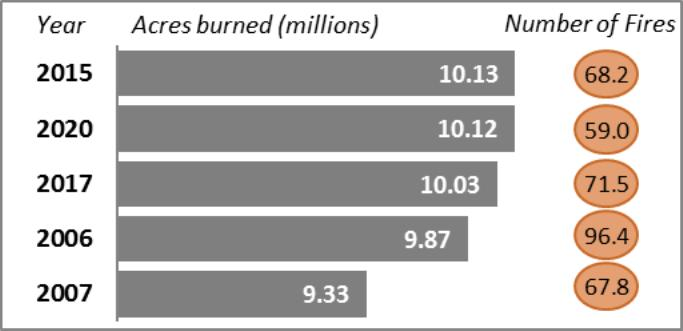

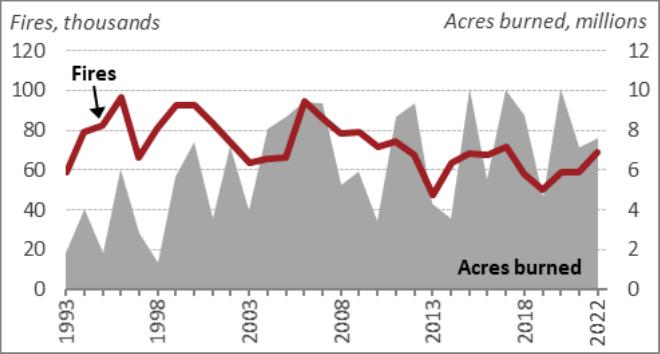

In [64]:
query = "Analyze the wildfires trend with acres burned over the years"
multimodal_rag_qa(query)

Answer:


The analysis of wildfire trends and acres burned over the years reveals several key points:

1. **Overall Trend**: 
   - The number of wildfires has shown variability but has generally decreased slightly over the last 30 years.
   - The number of acres burned annually has generally increased over the same period.

2. **Specific Years**:
   - The years 2015, 2020, and 2017 saw over 10 million acres burned, with 2015 having the highest at 10.13 million acres.
   - The number of fires in these years varied, with 2017 having the highest number of fires at 71.5 thousand.

3. **Decadal Averages**:
   - Since 2000, an average of 70,025 wildfires have burned about 7.0 million acres annually.
   - This is more than double the average annual acreage burned in the 1990s, which was 3.3 million acres, despite a higher average number of fires in the 1990s (78,600).

4. **Recent Data (2013-2022)**:
   - An average of 61,410 wildfires occurred annually, impacting an average of 7.2 million acres each year.
   - In 2022, 68,988 wildfires burned 7.6 million acres, with a significant portion (over 40%) occurring in Alaska.

5. **Graphical Insights**:
   - The first graph shows the top years for acres burned, with 2015 leading.
   - The second graph illustrates the variability in both the number of fires and acres burned, with a noticeable increase in acres burned over time.

Overall, while the number of wildfires has slightly decreased, the area affected by these fires has increased, indicating larger and potentially more intense fires in recent years.

----------------------------------------------------------------------------------------------------
Sources:


page_content='a. aa = Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 12 100 Fires 10 80 oN FD

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.' metadata={'source': './IF10244.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-09-02T11:45:21', 'page_number': 1, 'orig_elements': 'eJzNWG1v2zgS/iuEgQMSwBJIipLIAPchlyKHHHDZYt3FfaiLgKIom1tZEvSS1Lu4/34zlJworm9xDeDsFWhhjjjDeeM8D/v594Ut7c5W/YPLF1dkUchUJCZOAxvJLBBRbgOZWBqYOBFpxIWUSiyWZLGzvc51r0Hn94Wp6zZ3le5t59el3tdD/7C1brPtQcI5paAziZ9c3m9BylIvbWpX9aj3+TNLaAgiFqovS3JY8TgNE7+OIxWmJwS4H9aLbt/1dodRfHTfbLlqtLGLf8OHwpW23zfWf/r4T/Tf7fTGPjTae7IwV+v1qh9yZ7v1umnrX63pu4fsa7tel1a31Xr98/XfycfpA+y1O/ew6tvB9ENr84dWb9brwm1g0R1+BCxg4a/NZuEjrzYDHOjDXNhqs/jipV3/sKtzVzjrk88pjwOqAso/MXYl4ivOULtBV6thl9kW04YR9fYbJnahQ6I1+Su5q4q63blqQ/qtJaXduK7UvXu0JLcZ1IV0rjKWMMUEuamrDfjZubrSJfnZdhCh2ZKVbR8dJAytT7m6wyRhBo+7RMmk0GkRBTKlJoCm0IGieRqkTOaFVZYam56vS7hKQ459IEPp++AgUHQSxIKH0SmBV/nDXsltDzWG3DwYqE/3AN2QwTYaxnCMOt1MZyvvLw1kz+bkH0MFxQP/KY/mBbrXbevL/AkVThSqMJFQJomC1MoEC8UDXfAs0JHgcWK0kHl07uvMVRSmswsdCRlGuI6FwOt7vB73v61IMmapeOci/cuVeeFaS1Y91KLrnenmNfrk+vLkJcqEyVUe50GUwYAVSkFZRGKDmDNqKDcRS9W5axNJ+qo2ksahwLWMBF6Y4/W4/221UTGn0Z9Um45oKNBQNXBSBRfKy5YEhmIJUx/GZon5q+BXYPTQvewYKj3027p1v4FsO+x0dbRBVzmxndHNQUSKtt6RBn6Z1mUgzYa2IgdQCX2XTP7AnqauOpeVlsD8ntben74mT8++91vdkwyGekXqilR1VdjctjC8Lzo0tiRlbXQ5+tK07hFklwQizcE/+83YpvfmvQQ9wQKhY3tyMAQZrAygH8QLAgJd1thxssCn1vq2Bd8/AbgcVDb1o20r/EBc98ZQDra8Z6P52xq29Qc0Ihe3q8v1wCkTT67fghbi2y/hKiQfbKPb3p9fF+R60zozlAjH43YDoxEDgmvwfDyB8kGkXgdzNTkNMZq27jpvm6mI7FxZQgOjGC0U/sO97kfEPHjoLwC5uAcPR9dfe4Q6d1VvWwfpuPjw093ldHz34s+zA5iyHdjF/FREUPq9D9XhfDjkKxQWjZSuQCPFgFbH6gOct4/YmDU40JJmyEpnDs2AW+6gKnDGuNHb7MIfwhSRxlmGg0oWTAVCGBlIBmQRiplxo6WxZ6SIQDhChnOITXNpXAuaHpA+ikJ1QjBqvG1yiURw+c6T69aTSOC25LqqBij7bJRBFa99W/wNRovNgQErFQVwBp8XcrRwoxsM6WQhM6XSPCuCIhXA4jSnQUaFDjJA5KhQMhMpP2shQSTYRA6mdZrIMJ7qdlowavxf8n1+dr5/O4IOINLQ+Wk+9kE29cE0NDrCOIW/hMEg8SrwC7Cc1Pfk9sP/xPCzyFJpizhIdATkRMcCuH6iA5tGNMmlEDqj5yMnsQqBxclITi/BcQ1B8bEXJI/D+IRg1HgrPRGS/VnUsXumjmRry4ZAHYeub/Hl1sAxI+I9w4aGAB5dvw8nUIJMwkMPqgDAvWvAf4/tr0DLI5FH+T08AKcyIb7cWPwCMHZ3c3MJhCh3Bk/1OI0WRscRgPQ4h16wHGD/UbdOI+ZnALNb3cFzExpSIz/qPKUq9wR5wvgsxUgiSvZwxSa0n1n3jayLYuQm42HlHnBuCwERXXb182lLAoEgcQDreCjQuOnQi84ChZhGJ8Dyyj97oe0ogt8hBP3oc4HHpnQJVZsFtYWP0336LxrhETiPkeBP3DEOA8zNC57n9YA5whwcDB3sTlrTgRO/gXFOO3IRhUdU5BKCKPHub7ZEE+BlGkv3ksMxgtqYoW1nOXxtFo1NTlykcplQevlj+K+0YUbnIjCC54GgNglUypKgoMqYWLLIWHlu/E9THvIZ/suYHkZFlCLcfycYNd44GqhK3xv/V/XQGntF8F567EcK54c5WQ27nW73nge8vDkPLdXapm6RrN8Dz78iH3AsAEUsIbSRM6LaC5HQMwCZOCaOk/nb6EhrxttROHuOjDT+hziI5qlNYhYHKjNAJmMTBVmaxEEW2ziL4yJj/OzNJIFipLNmYpSpZ/LIPfJ8Jxl13thOQkXpe9NJfJTCuyjC5xgyRSQRFprpCf/R1XzCJWwpgC88zQjnNEh8w1SvpyE/eqq4HWRgPsJDAJ/pyEQulZQzy1PfpWFyPFN/QtQQ9C/jU6oeH2n4dkJ/YaBdQ1K+ahyS7GhI/tg0S3PDWSFsIBhHEsxoICmVgSoyoMVxrgrDzt2AjMavnzMM/owC6LfEU53vJaPSG1uQpfF7/2fmtX/Gzv8rE+CsrQfoKSaXEaXHKPzcSZ5BxIwtAcenNui3gLBIJP6o2l/+A8XqwIE=', 'file_directory': '.', 'filename': 'IF10244.pdf', 'category': 'CompositeElement', 'element_id': '150202048ae0d2bf64f0f9b13527581a'}

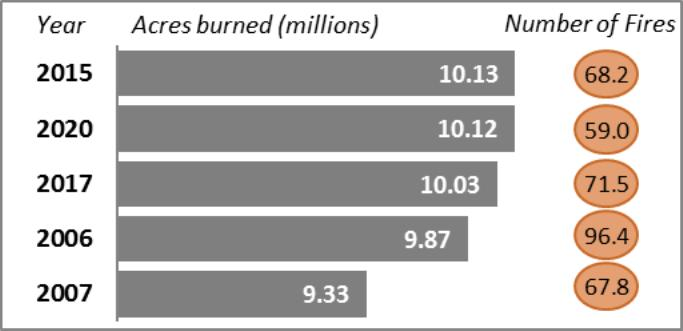

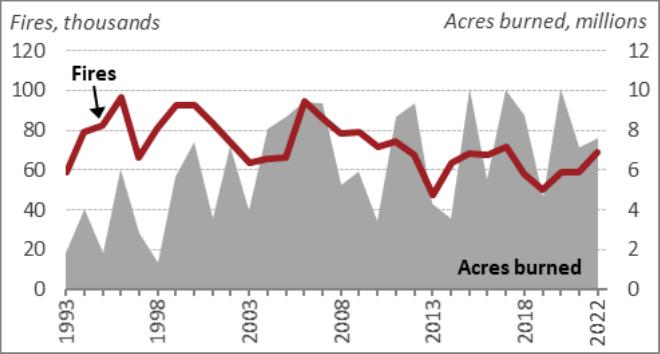

In [65]:
# Run RAG chain
query = "Analyze the wildfires trend with acres burned over the years"
multimodal_rag_qa(query)